## **Machine Learning with Discovery records**

** This tutorial uses data created by Tutorial 2. If you haven't already done that one, please go through it now **

Now that we've prepared our datasets it is time to try some machine learning. This tutorial will follow a repetitive pattern:



*   Load one of the preprocessed files
*   Run machine learning algorithms

*   Compare their results

We will also encounter some new ML algorithms for the first time and also use an old one. The algorithms we will use are:



*   Decision Tree
*   Naive Bayes

*   Support Vector Machine


A full explanation of the new ones will be provided in supplementary material but briefly, Naive Bayes is a very simple but effective model based on probabilities, and Support Vector Machine (SVM) is more complex but analogous to the "placing the string between the dots" activity we did in session 2.

So we have 3 datasets and 3 algorithms, which makes 9 possible experiments. The tutorial is designed to make it easy to try all combinations and compare the results at the end.









In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data_folder = "/content/gdrive/My Drive/MLC/Session 3/Data/"

This piece of code imports the libraries that we will be using in the first part of this notebook.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn      # The most common Python Machine Learning library - scikit learn
from sklearn.model_selection import train_test_split  # Used to create training and test data
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from operator import itemgetter
from nltk.stem.porter import *
import pickle
from nltk import toktok    

This tutorial uses datasets created by tutorial 2. 

The files are called:


*   word_tfidf.pck
*   ngram_tfidf.pck

*   stemmed_ngram_tfidf.pck


**If they don't appear in the list output by the following line of code then rerun tutorial 2.**



In [0]:
os.listdir(data_folder)

['taxonomyids_and_names.txt',
 'taxonomy_descriptions.txt',
 'topN_taxonomy.csv',
 'word_tfidf.pck',
 'ngram_tfidf.pck',
 'stemmed_ngram_tfidf.pck']

We will start by setting up some variables for later use. First of all we set the value of N. If you ran the previous tutorials with it set to 10 (the default) then leave it as it is, otherwise change it to match what you did in those tutorials. Next we need to recreate the stemming function from tutorial 2.
Then we create two lists (data_sources and algorithms) which hold the names of our data files (that you just checked existed) and the ML algorithms we're going to try out on our data, respectively.
Finally, we create a table to capture the results of our experiments in. This will contain a row for each combination of data and algorithm, so 9 in total (3 x 3).

In [0]:
N = 10

class PorterTokenizer:
    def __init__(self):
        self.porter = PorterStemmer()
    def __call__(self, doc):
        ttt = toktok.ToktokTokenizer()
        return [self.porter.stem(t) for t in ttt.tokenize(doc)]

data_sources = [['Word level TFIDF', 'word_tfidf.pck', 'word'],
                ['NGram level TFIDF', 'ngram_tfidf.pck', 'ngram'],
                ['Stemmed NGram TFIDF', 'stemmed_ngram_tfidf.pck', 'stemmed']]

algorithms = [['Decision Tree', DecisionTreeClassifier(max_depth=10), False, 'DT'],
              ['Naive Bayes', MultinomialNB(), True, 'NB'],
              ['Support Vector Machine', svm.SVC(), False, 'SVM']]

results = pd.DataFrame(columns = ['data', 'algorithm', 'accuracy', 'balanced_accuracy'])

for d in data_sources:
    for a in algorithms:
        results.loc[len(results)] = [d[0],a[0],0,0]
results


,data,algorithm,accuracy,balanced_accuracy
0,Word level TFIDF,Decision Tree,0,0
1,Word level TFIDF,Naive Bayes,0,0
2,Word level TFIDF,Support Vector Machine,0,0
3,NGram level TFIDF,Decision Tree,0,0
4,NGram level TFIDF,Naive Bayes,0,0
5,NGram level TFIDF,Support Vector Machine,0,0
6,Stemmed NGram TFIDF,Decision Tree,0,0
7,Stemmed NGram TFIDF,Naive Bayes,0,0
8,Stemmed NGram TFIDF,Support Vector Machine,0,0


In [0]:
data_sources = [['Word level TFIDF', 'word_tfidf.pck', 'word'],
                ['NGram level TFIDF', 'ngram_tfidf.pck', 'ngram'],
                ['Stemmed NGram TFIDF', 'stemmed_ngram_tfidf.pck', 'stemmed']]

algorithms = [['Decision Tree', DecisionTreeClassifier(max_depth=10), False, 'DT'],
              ['Naive Bayes', GaussianNB(), True, 'NB'],
              ['Support Vector Machine', svm.SVC(), False, 'SVM']]

We also need to load the Discovery data and descriptions which we have used in our tutorials so far. The first file is the descriptions for the top 10 categories (assuming that's what you set N to be in tutorial 1), and the second is the taxonomy description lookup.
Just to check it is all working you should see the number of records by category, which should match what you created in tutorial 1 (no need to check unless something looks really odd).

In [0]:
descriptions = pd.read_csv(data_folder + 'topN_taxonomy.csv',
                           delimiter="|", header=0, lineterminator='\n')
descriptions = descriptions.drop(descriptions.columns[[0]], axis=1) 
descriptions.columns = ["IAID","TAXID","Description"]

taxonomy = pd.read_csv(data_folder + 'taxonomyids_and_names.txt',
                           delimiter="|", header=None, lineterminator='\n')
taxonomy.columns = ["TAXID","TaxonomyCategory"]

topN = pd.merge(descriptions, taxonomy, how = 'inner').groupby(['TAXID', 'TaxonomyCategory']).size().reset_index(name='Count').sort_values('Count', ascending=False)
topN

,TAXID,TaxonomyCategory,Count
5,C10092,Army,17113
1,C10005,"Art, architecture and design",14114
3,C10060,Medals,12049
4,C10072,Navy,10691
0,C10002,Air Force,6682
2,C10058,Maps and plans,5805
9,C10131,Europe and Russia,4790
8,C10127,Indian Subcontinent,3275
6,C10106,Taxation,3144
7,C10108,Trade and commerce,2891


To use the tutorial all you need to do is change the first two variables in the code below (DATA and ALGORITHM) and run the code. The results table will be updated each time you run to keep a record of results for each combination. Algorithm 3 (SVM) is quite slow, so be patient with it. Its runtime will depend on how many features you created in tutorial 2, so you may want to rerun that one will a smaller MAX_FEATURES value if you're finding it too slow.

Each time you run the code it will output:


*   The name of the algorithm
*   The name of the dataset
*   Training and Testing accuracy figures.
*   A confusion matrix with a lookup table of taxonomy categories


It will also save your model into the data folder for the next tutorial.

After each run inspect the confusion matrix to look for any categories which are often misclassified. In particular look for big numbers (or squares which are not coloured black) off the diagonal.

Things to remember from previous sessions:


*   There are two accuracy figures: **accuracy** and **balance accuracy**. The latter takes into account the proportions of the dataset for each category, so is good for imbalanced datasets.
*   If there is a large discrepancy between Training and Testing accuracy, it indicates that the algorithm is **overfitting** to the training data and may be less reliable 'in the wild'.
*   The rows of the **confusion matrix** represent the 'true' values, the columns are the predictions.



**Are any of the algorithms better or worse in this respect?**

**Are there particular categories which are consistently misclassified?**

**Add an extra dimension to your experimentation by increasing the numbers of features in the datasets you created in Tutorial 2 (rerun that tutorial with different MAX_FEATURES values) to see the effect more, or fewer, features has on the results.**

The results for each run are being captured in the table we created earlier so we can compare each one. If you want to track this as you go, there is a line of code to view the results table after this one. Scroll down to find it.

Algorithm: Decision Tree
Dataset: Word level TFIDF
Train Accuracy: 0.748; Balanced: 0.675
Test Accuracy:  0.745; Balanced: 0.671


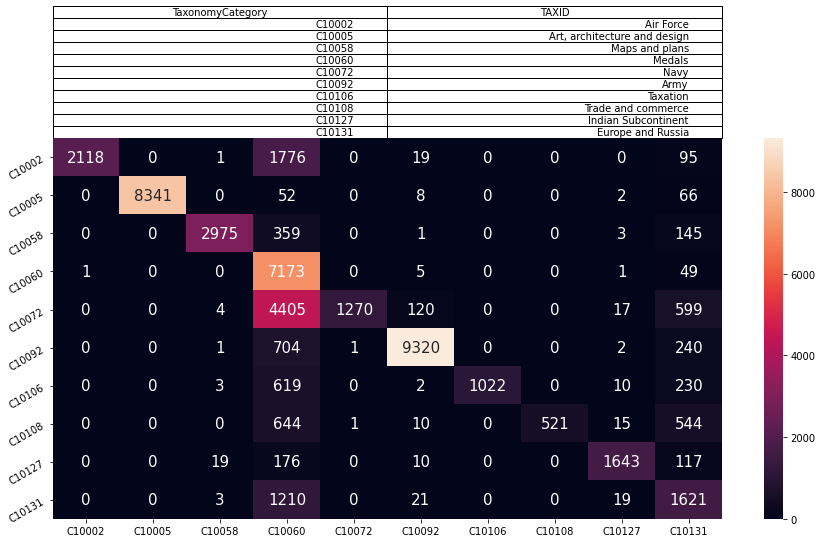

In [0]:
DATA = 1       # Choose a number between 1 and 3
ALGORITHM = 1  # Choose a number between 1 and 3

vectoriser = pickle.load(open(data_folder + data_sources[DATA-1][1], 'rb'))

training_set, testing_set = train_test_split(descriptions, train_size = 0.4, stratify = descriptions.TAXID)
X_train = vectoriser.transform(training_set.Description)
y_train = training_set.TAXID

if algorithms[ALGORITHM-1][2]:
    model = algorithms[ALGORITHM-1][1].fit(X_train.toarray(), y_train)  # The Naive Bayes algorithm doesn't work with sparse matrices
else:
    model = algorithms[ALGORITHM-1][1].fit(X_train, y_train)

pickle.dump(model, open(data_folder + 'model_' + algorithms[ALGORITHM-1][3] + "_" + data_sources[DATA-1][2] + '.pck', 'wb'))
X_test = vectoriser.transform(testing_set.Description)
y_test = testing_set.TAXID
if algorithms[ALGORITHM-1][2]:
    y_train_pred = model.predict(X_train.toarray())
    y_test_pred = model.predict(X_test.toarray())
else:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


test_accuracy = accuracy_score(y_test, y_test_pred)
test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
results.loc[(results.algorithm == algorithms[ALGORITHM-1][0]) & (results.data == data_sources[DATA-1][0]), ['accuracy','balanced_accuracy']] = [test_accuracy, test_balanced_accuracy]

print("Algorithm:", algorithms[ALGORITHM-1][0])
print("Dataset:", data_sources[DATA-1][0])
print("Train Accuracy: %0.3f; Balanced: %0.3f" % (accuracy_score(y_train, y_train_pred), balanced_accuracy_score(y_train, y_train_pred)))
print("Test Accuracy:  %0.3f; Balanced: %0.3f" % (test_accuracy, test_balanced_accuracy))

fig, ax = plt.subplots(1,1,figsize=(15, 7))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_test_pred, normalize=None), range(N), range(N)), annot=True, annot_kws={"size": 15}, fmt='g', ax = ax)
ax.table(cellText=topN[{'TaxonomyCategory','TAXID'}].sort_values(by='TAXID').values, colLabels=['TaxonomyCategory','TAXID'], loc='top')
ax.set_xticklabels(model.classes_)
ax.set_yticklabels(model.classes_, rotation = 30)
plt.show()


This line can be used to view the results of the various combinations of algorithm and dataset. A discussion of the results will follow.

In [0]:
results

,data,algorithm,accuracy,balanced_accuracy
0,Word level TFIDF,Decision Tree,0.746426,0.670866
1,Word level TFIDF,Naive Bayes,0.865765,0.823629
2,Word level TFIDF,Support Vector Machine,0.937393,0.918884
3,NGram level TFIDF,Decision Tree,0.746322,0.670984
4,NGram level TFIDF,Naive Bayes,0.897213,0.868668
5,NGram level TFIDF,Support Vector Machine,0.944407,0.925981
6,Stemmed NGram TFIDF,Decision Tree,0.770116,0.673001
7,Stemmed NGram TFIDF,Naive Bayes,0.862123,0.835571
8,Stemmed NGram TFIDF,Support Vector Machine,0,0


We can also draw a graph of the results.

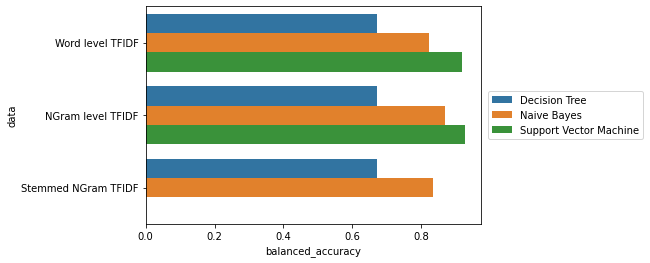

In [0]:
bar = sns.barplot(x = "balanced_accuracy", y = "data", data = results, hue = "algorithm" )
bar.legend(loc='right', bbox_to_anchor=(1.5, 0.5))

**Discussion of the results**

Everyone's results will be slightly different, depending on the number of features they selected and their training set. However, if your results are similar to mine then you should see the following:


1.   Support Vector Machine returns the best results, followed by Naive Bayes, and then Decision Tree
2.   Overall the including 2 and 3 word combinations in our training data produces slightly better results than using single words.

1.   For this dataset using the Porter stemmer didn't improve results
2.   The choice of dataset doesn't seem to make much difference with Naive Bayes









So overall it appears that we should select Support Vector Machine as our Taxonomy classifier.
In the next tutorial we will delve further into whether that is the right decision. We will also use our classifiers to predict categories for specific descriptions and look further at the results that come out of the predictions.

That's the end of this tutorial in which you have gained some experience in running and comparing the results of 3 different algorithms. 


In the next tutorial we will look more closely at the models in action and also explore ways of explaining their outputs.

